Libraries:

In [69]:
import warnings
warnings.filterwarnings('ignore')
import winsound

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

from IPython.display import Image
from celluloid import Camera
from matplotlib.animation import PillowWriter

from matplotlib.pyplot import figure
from tsfresh.utilities.dataframe_functions import impute
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from tsfresh import extract_features

import seaborn as sns
import matplotlib.patches as mpatches
from pylab import rcParams

from gluonts.model.deepar import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.seasonal_naive import SeasonalNaivePredictor
from gluonts.evaluation import Evaluator
from gluonts.trainer import Trainer
from itertools import islice

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import make_forecasting_frame

import statsmodels.formula.api as smf
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from tqdm import tqdm

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

Parameters:

In [6]:
predictions = 24
integration_order = 1
season_integration_order = 1 
season_period = 24

CDFs:

In [159]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotMovingAverage(series, window, center=True, plot_intervals=False, scale=1.96, plot_anomalies=False):

    rolling_mean = series.rolling(window=window, center=center).mean()
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    if plot_intervals:
        mae = mean_absolute_error(series[window:].fillna(0), rolling_mean[window:].fillna(0))
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax, style="-o")
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
        plt.tight_layout() 
        
def timeseries_train_test_split(X, y, test_size):
   
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test
    
def plotCoefficients(model):
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(8, 4))
    coefs.coef.plot(kind='bar')
    plt.title('Linear regression factors:')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    
def product(*args):
    if not args:
        return iter(((),)) 
    return (items + (item,) 
            for items in product(*args[:-1]) for item in args[-1])

def optimizeSARIMA(parameters_list, d, D, s):

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        try:
            model=sm.tsa.statespace.SARIMAX(df.y, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic

        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
    
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    data['arima_model'][:s+d] = np.NaN

    forecast = best_model.get_forecast(steps=50)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(8, 5))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'], 
                         y2=intervals['lower'], alpha=0.2, color = "grey")    
    
    
    plt.legend()
    plt.grid(True)
    
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):

    errors = []
    values = series.values
    alpha, beta, gamma = params
    
    tscv = TimeSeriesSplit(n_splits=3) 
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

class HoltWinters:
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
 
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))

        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])
            
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    
    plt.figure(figsize=(8, 5))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13)
    
class LoopingPillowWriter(PillowWriter):
    def finish(self):
        self._frames[0].save(self._outfile, save_all=True, append_images=self._frames[1:],
                             duration=int(1000/self.fps), loop=0)
        
def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2, markersize=5)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()        

Import data:

In [179]:
df = pd.read_excel('cluster/cpu.xlsx', sheet_name='First')
df['Date'] = pd.to_datetime(df['Date'])
df.columns = ['ds', 'y']

print('Start:', str(df['ds'].iloc[1])[:10])
print('End:', str(df['ds'].iloc[-1])[:10])

df.set_index(keys='ds', inplace=True)
df.head()

Start: 2020-02-26
End: 2020-04-07


,y
ds,
2020-02-26 00:00:00,2400
2020-02-26 01:00:00,2430
2020-02-26 02:00:00,2518
2020-02-26 03:00:00,1015
2020-02-26 04:00:00,2480


Correlation cpu vs ram:

Correllation CPU vs RAM: 86 %


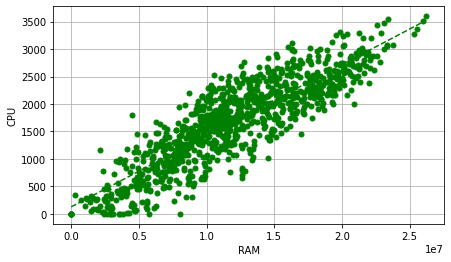

In [180]:
df_ram = pd.read_excel('cluster/ram.xlsx', sheet_name='First') 
df_cpu = pd.read_excel('cluster/cpu.xlsx', sheet_name='First')

df_ram.columns = ['date', 'y']
df_cpu.columns = df_ram.columns
print('Correllation CPU vs RAM:', int(100*np.corrcoef(list(df_ram['y']), list(df_cpu['y']))[1][0]), '%')

plt.figure(figsize=(7,4))
plt.plot(df_ram['y'], df_cpu['y'], '.', markersize=10, color='green')

x, y = np.unique(df_ram['y']), np.poly1d(np.polyfit(df_ram['y'], df_cpu['y'], 1))
plt.plot(x, y(x), '--g')

plt.ylabel('CPU vs RAM load')
plt.xlabel('RAM')
plt.ylabel('CPU')

plt.grid()
plt.show()

Plot CPU load:

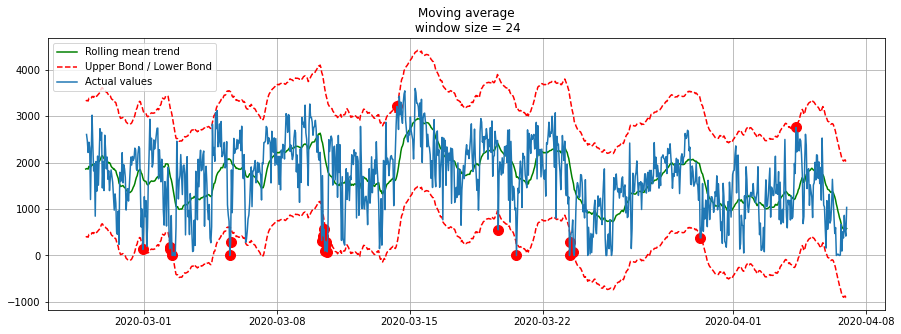

In [181]:
plotMovingAverage(df, 24, plot_intervals=True, center=False, scale=1.5, plot_anomalies=True)

ADF test:

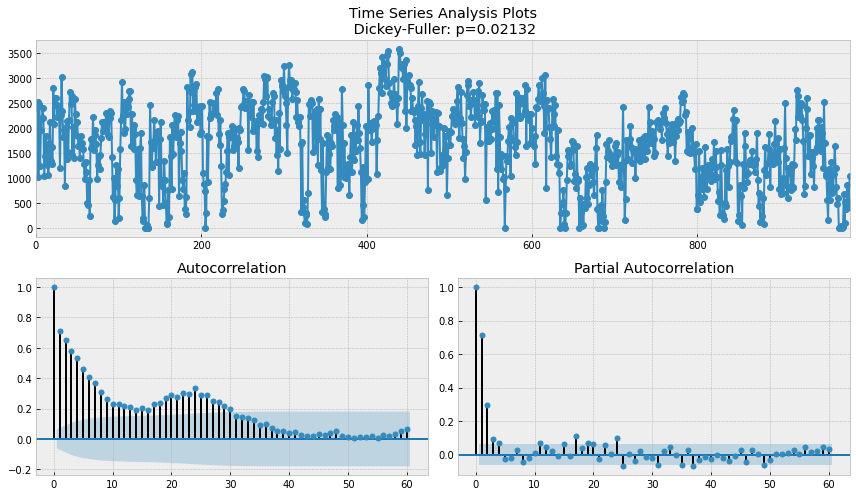

In [182]:
df.reset_index(inplace=True)
tsplot(df['y'], lags=60)

Cyclical adjusted time series (CATS):

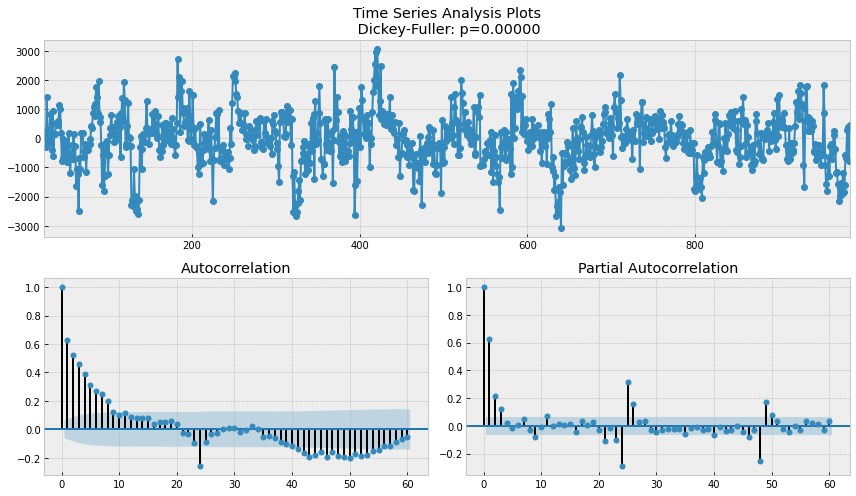

In [183]:
df_diff = df.copy()
df_diff['y'] = df['y'] - df['y'].shift(season_period)
df_diff.dropna(inplace=True)
tsplot(df_diff['y'], lags=60)

Normalize time series:

In [184]:
df['y'] = df['y'].apply(lambda x: (x - min(df['y'])))
df['y'] = df['y'].apply(lambda x: (x + 0.01*(max(df['y'])-min(df['y']))))

Baseline MAPE:

In [185]:
df['y-1'] = df['y'].shift(1)
df_diff.dropna(inplace=True)

error = mean_absolute_percentage_error(df['y'], df['y-1'])
print('Baseline MAPE:', int(error), '%')

Baseline MAPE: 58 %


GluonTS - dataset:

In [186]:
df_gts = pd.read_excel('cluster/cpu.xlsx', sheet_name='First')
df_gts.index = pd.to_datetime(df_gts['Date'])
df_gts.columns = ['Date', 'Load']

print('Start:', str(df_gts['Date'].iloc[1])[:10])
print('End:', str(df_gts['Date'].iloc[-1])[:10])

df_gts.tail(20)

Start: 2020-02-26
End: 2020-04-07


,Date,Load
Date,,
2020-04-06 05:00:00,2020-04-06 05:00:00,1073
2020-04-06 06:00:00,2020-04-06 06:00:00,1640
2020-04-06 07:00:00,2020-04-06 07:00:00,1208
2020-04-06 08:00:00,2020-04-06 08:00:00,824
2020-04-06 09:00:00,2020-04-06 09:00:00,473
2020-04-06 10:00:00,2020-04-06 10:00:00,601
2020-04-06 11:00:00,2020-04-06 11:00:00,0
2020-04-06 12:00:00,2020-04-06 12:00:00,16
2020-04-06 13:00:00,2020-04-06 13:00:00,31


Train model:

In [175]:
estimator = DeepAREstimator(freq='H', prediction_length=20, trainer=Trainer(epochs=500))
training_data = ListDataset([{"start": df_gts.index[0], 'target': df_gts['Load'][:'2020-04-06 05:00:00']}], freq = 'H')
predictor = estimator.train(training_data=training_data)
winsound.Beep(440, 1000)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in DeepARTrainingNetwork: 27644
100%|██████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.07it/s, avg_epoch_loss=8.1]
INFO:root:Epoch[0] Elapsed time 3.559 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.102169
INFO:root:Epoch[1] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.65it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[1] Elapsed time 3.007 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.679309
INFO:root:Epoch[2] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.63it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[2] Elapsed time 3.011 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.581674
INFO:root:Epoch[3] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.29it/s, avg_epoch_loss=7.53]
INFO:root:Epoch[

100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.17it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[30] Elapsed time 2.919 seconds
INFO:root:Epoch[30] Evaluation metric 'epoch_loss'=6.630817
INFO:root:Epoch[31] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.40it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[31] Elapsed time 3.054 seconds
INFO:root:Epoch[31] Evaluation metric 'epoch_loss'=6.645357
INFO:root:Epoch[32] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.69it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[32] Elapsed time 3.000 seconds
INFO:root:Epoch[32] Evaluation metric 'epoch_loss'=6.584691
INFO:root:Epoch[33] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.73it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[33] Elapsed time 2.993 seconds
INFO:root:Epoch[33] Eva

100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.72it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[60] Elapsed time 2.997 seconds
INFO:root:Epoch[60] Evaluation metric 'epoch_loss'=6.231094
INFO:root:Epoch[61] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.96it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[61] Elapsed time 2.954 seconds
INFO:root:Epoch[61] Evaluation metric 'epoch_loss'=6.264844
INFO:root:Epoch[62] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.17it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[62] Elapsed time 2.914 seconds
INFO:root:Epoch[62] Evaluation metric 'epoch_loss'=6.213713
INFO:root:Epoch[63] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.49it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[63] Elapsed time 3.038 seconds
INFO:root:Epoch[63] Eva

100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.49it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[90] Elapsed time 2.861 seconds
INFO:root:Epoch[90] Evaluation metric 'epoch_loss'=5.974105
INFO:root:Epoch[91] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.91it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[91] Elapsed time 2.796 seconds
INFO:root:Epoch[91] Evaluation metric 'epoch_loss'=6.023540
INFO:root:Epoch[92] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.53it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[92] Elapsed time 2.855 seconds
INFO:root:Epoch[92] Evaluation metric 'epoch_loss'=5.941468
INFO:root:Epoch[93] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.59it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[93] Elapsed time 2.847 seconds
INFO:root:Epoch[93] Eva

100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.30it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[120] Elapsed time 2.894 seconds
INFO:root:Epoch[120] Evaluation metric 'epoch_loss'=5.878584
INFO:root:Epoch[121] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.06it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[121] Elapsed time 2.935 seconds
INFO:root:Epoch[121] Evaluation metric 'epoch_loss'=5.785190
INFO:root:Epoch[122] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.41it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[122] Elapsed time 2.875 seconds
INFO:root:Epoch[122] Evaluation metric 'epoch_loss'=5.816690
INFO:root:Epoch[123] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.86it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[123] Elapsed time 2.804 seconds
INFO:root:Epo

100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.89it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[150] Elapsed time 2.799 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.650722
INFO:root:Epoch[151] Learning rate is 0.001
100%|██████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.23it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[151] Elapsed time 2.907 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_loss'=5.703124
INFO:root:Epoch[152] Learning rate is 0.001
100%|██████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.44it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[152] Elapsed time 2.870 seconds
INFO:root:Epoch[152] Evaluation metric 'epoch_loss'=5.602540
INFO:root:Epoch[153] Learning rate is 0.001
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.77it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[153] Elapsed time 2.819 seconds
INFO:root:Epo

INFO:root:Epoch[180] Learning rate is 0.0005
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.23it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[180] Elapsed time 2.904 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=5.518641
INFO:root:Epoch[181] Learning rate is 0.0005
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.60it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[181] Elapsed time 2.847 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=5.512756
INFO:root:Epoch[182] Learning rate is 0.0005
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.32it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[182] Elapsed time 2.891 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.479374
INFO:root:Epoch[183] Learning rate is 0.0005
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.07it/s, avg_epoch_loss=5.52]
INFO:root:Epo

INFO:root:Epoch[209] Evaluation metric 'epoch_loss'=5.450767
INFO:root:Epoch[210] Learning rate is 0.00025
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.95it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[210] Elapsed time 3.137 seconds
INFO:root:Epoch[210] Evaluation metric 'epoch_loss'=5.458557
INFO:root:Epoch[211] Learning rate is 0.00025
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.42it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[211] Elapsed time 3.049 seconds
INFO:root:Epoch[211] Evaluation metric 'epoch_loss'=5.421584
INFO:root:Epoch[212] Learning rate is 0.00025
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.72it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[212] Elapsed time 3.187 seconds
INFO:root:Epoch[212] Evaluation metric 'epoch_loss'=5.491307
INFO:root:Epoch[213] Learning rate is 0.00025
100%|█████████████████████████████████████████████████████████████| 

100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.14it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[239] Elapsed time 2.920 seconds
INFO:root:Epoch[239] Evaluation metric 'epoch_loss'=5.422866
INFO:root:Epoch[240] Learning rate is 0.000125
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.89it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[240] Elapsed time 2.964 seconds
INFO:root:Epoch[240] Evaluation metric 'epoch_loss'=5.392586
INFO:root:Epoch[241] Learning rate is 0.000125
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.91it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[241] Elapsed time 2.796 seconds
INFO:root:Epoch[241] Evaluation metric 'epoch_loss'=5.406831
INFO:root:Epoch[242] Learning rate is 0.000125
100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.87it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[242] Elapsed time 2.802 seconds
INFO

INFO:root:Epoch[268] Evaluation metric 'epoch_loss'=5.433008
INFO:root:Epoch[269] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.93it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[269] Elapsed time 3.142 seconds
INFO:root:Epoch[269] Evaluation metric 'epoch_loss'=5.407537
INFO:root:Epoch[270] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.38it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[270] Elapsed time 3.256 seconds
INFO:root:Epoch[270] Evaluation metric 'epoch_loss'=5.419720
INFO:root:Epoch[271] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.85it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[271] Elapsed time 3.159 seconds
INFO:root:Epoch[271] Evaluation metric 'epoch_loss'=5.392738
INFO:root:Epoch[272] Learning rate is 5e-05
100%|██████████████████████████████████████████████████████████████| 50/50 [

INFO:root:Epoch[299] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.06it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[299] Elapsed time 3.117 seconds
INFO:root:Epoch[299] Evaluation metric 'epoch_loss'=5.378512
INFO:root:Epoch[300] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.79it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[300] Elapsed time 3.174 seconds
INFO:root:Epoch[300] Evaluation metric 'epoch_loss'=5.424860
INFO:root:Epoch[301] Learning rate is 5e-05
100%|██████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.27it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[301] Elapsed time 3.277 seconds
INFO:root:Epoch[301] Evaluation metric 'epoch_loss'=5.403646
INFO:root:Epoch[302] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.36it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[3

100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.06it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[329] Elapsed time 3.118 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.368641
INFO:root:Epoch[330] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.04it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[330] Elapsed time 3.121 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.383392
INFO:root:Epoch[331] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.99it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[331] Elapsed time 3.131 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.372067
INFO:root:Epoch[332] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.04it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[332] Elapsed time 3.122 seconds
INFO:root:Epo

100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.79it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[359] Elapsed time 3.169 seconds
INFO:root:Epoch[359] Evaluation metric 'epoch_loss'=5.344838
INFO:root:Epoch[360] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.47it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[360] Elapsed time 3.460 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=5.379915
INFO:root:Epoch[361] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.72it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[361] Elapsed time 3.402 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=5.381328
INFO:root:Epoch[362] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.27it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[362] Elapsed time 3.772 seconds
INFO:root:Epo

100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.57it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[389] Elapsed time 3.216 seconds
INFO:root:Epoch[389] Evaluation metric 'epoch_loss'=5.356272
INFO:root:Epoch[390] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.94it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[390] Elapsed time 3.140 seconds
INFO:root:Epoch[390] Evaluation metric 'epoch_loss'=5.374960
INFO:root:Epoch[391] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.87it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[391] Elapsed time 3.154 seconds
INFO:root:Epoch[391] Evaluation metric 'epoch_loss'=5.358614
INFO:root:Epoch[392] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.96it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[392] Elapsed time 3.137 seconds
INFO:root:Epo

100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.86it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[419] Elapsed time 3.156 seconds
INFO:root:Epoch[419] Evaluation metric 'epoch_loss'=5.336182
INFO:root:Epoch[420] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.15it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[420] Elapsed time 3.305 seconds
INFO:root:Epoch[420] Evaluation metric 'epoch_loss'=5.356407
INFO:root:Epoch[421] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.80it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[421] Elapsed time 3.168 seconds
INFO:root:Epoch[421] Evaluation metric 'epoch_loss'=5.354650
INFO:root:Epoch[422] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.69it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[422] Elapsed time 3.191 seconds
INFO:root:Epo

100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.92it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[449] Elapsed time 3.144 seconds
INFO:root:Epoch[449] Evaluation metric 'epoch_loss'=5.306782
INFO:root:Epoch[450] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.49it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[450] Elapsed time 3.037 seconds
INFO:root:Epoch[450] Evaluation metric 'epoch_loss'=5.351804
INFO:root:Epoch[451] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.87it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[451] Elapsed time 3.153 seconds
INFO:root:Epoch[451] Evaluation metric 'epoch_loss'=5.334985
INFO:root:Epoch[452] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.89it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[452] Elapsed time 3.150 seconds
INFO:root:Epo

100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.94it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[479] Elapsed time 3.140 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=5.323889
INFO:root:Epoch[480] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.93it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[480] Elapsed time 3.142 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=5.314976
INFO:root:Epoch[481] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.45it/s, avg_epoch_loss=5.28]
INFO:root:Epoch[481] Elapsed time 3.045 seconds
INFO:root:Epoch[481] Evaluation metric 'epoch_loss'=5.280508
INFO:root:Epoch[482] Learning rate is 5e-05
100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.21it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[482] Elapsed time 3.090 seconds
INFO:root:Epo

Make forecast:

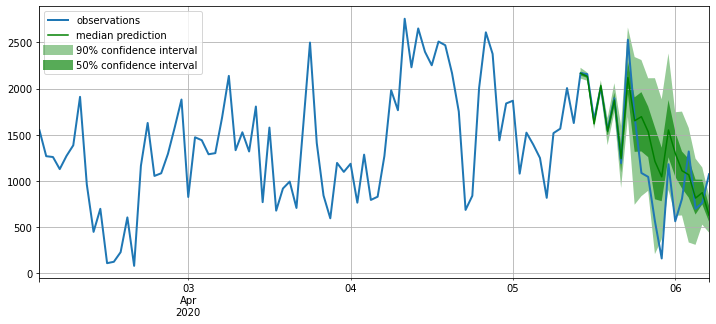

In [176]:
test_data = training_data
forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=100, num_plots=3)

Evaluation:

In [177]:
evaluator = Evaluator(quantiles=[0.5])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))
print('Simmetric MAPE:', int(100*agg_metrics['sMAPE']),'%')

Running evaluation: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.62it/s]

Simmetric MAPE: 28 %


Feature generation:

In [187]:
data = pd.DataFrame(df['y'].copy())
data.columns = ['y']

for i in range(1, 30):
    data["lag_{}".format(i)] = data.y.shift(i)

Correlation between features:

[]

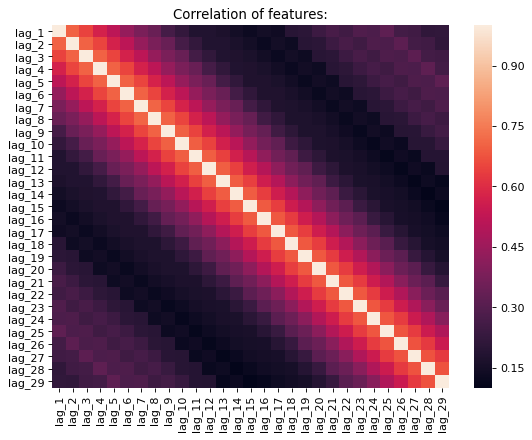

In [188]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(X_train.corr())
plt.title('Correlation of features:')
rcParams['figure.figsize'] = 5, 10
plt.plot()

Linear regression model:

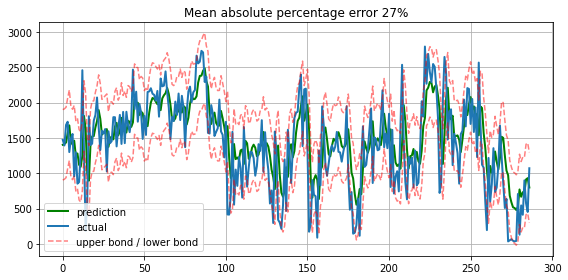

In [189]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(8, 4))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=TimeSeriesSplit(), 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.0f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

lasso = LassoCV(cv=TimeSeriesSplit(), eps=0.01)
lasso.fit(X_train, y_train)
plotModelResults(lasso, X_train=X_train, X_test=X_test, plot_intervals=True, plot_anomalies=False)

Plot coefficients of TS memory:

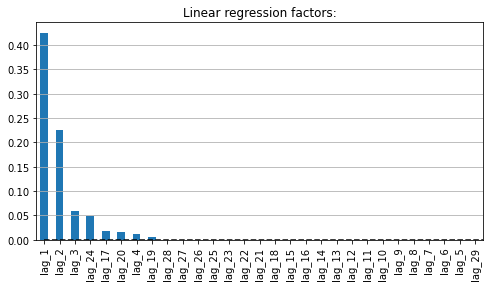

In [190]:
plotCoefficients(lasso)

Fit ARIMA model:

In [191]:
%%time
ps = range(2, 5)
qs = range(2, 10)
Ps = range(0, 2)
Qs = range(0, 2)

parameters_list = list(product(ps, qs, Ps, Qs))
result_table = optimizeSARIMA(parameters_list, integration_order, season_integration_order, season_period)


Wall time: 1h 15min 14s


Choose best model:

In [192]:
p, q, P, Q = result_table.parameters[0]
best_model=sm.tsa.statespace.SARIMAX(df['y'], order=(p, 1, q), seasonal_order=(P, 1, Q, 24)).fit(disp=-1)

Plot residuals:

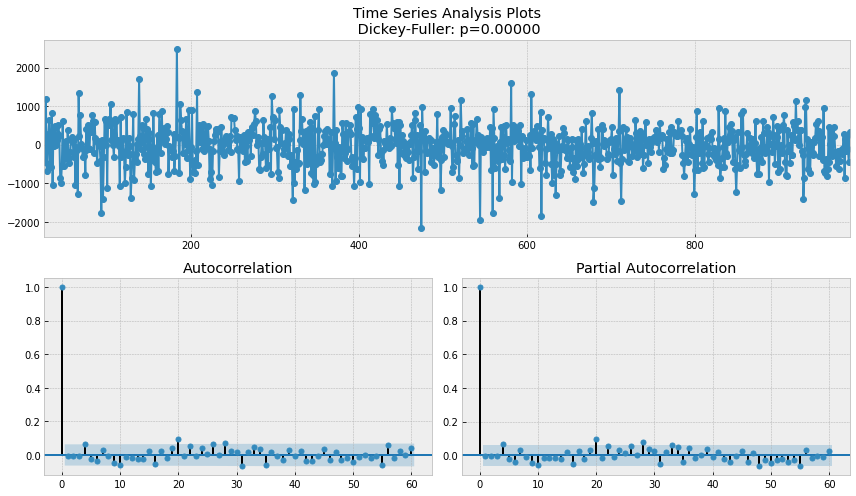

In [193]:
tsplot(best_model.resid[24+1:], lags=60)

Plot SARIMA forecast:

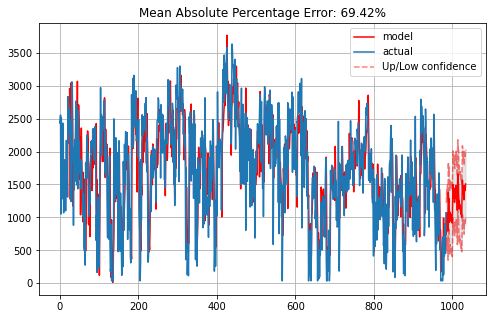

In [194]:
plotSARIMA(pd.DataFrame(df['y']), best_model, 50, alpha=0.5)

Holt - Winters model:

0.003461683139545424 0.013789320044076125 0.0
Wall time: 7.11 s


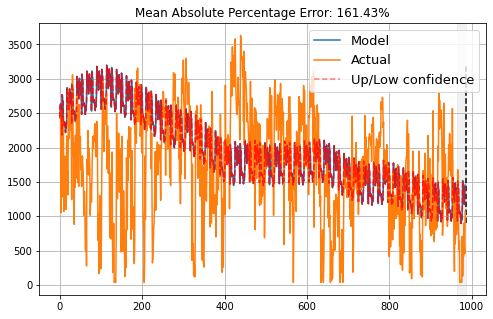

In [195]:
%%time
x = [0, 0, 0]
data = df['y'][:-20]
opt = minimize(timeseriesCVscore, x0=x, args=(data, mean_squared_error), method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = 24, alpha = alpha_final, beta = beta_final, 
gamma = gamma_final, n_preds = 20, scaling_factor = 2)

model.triple_exponential_smoothing()
plotHoltWinters(df['y'], plot_intervals=True, plot_anomalies=False)

Gradient Boosting:

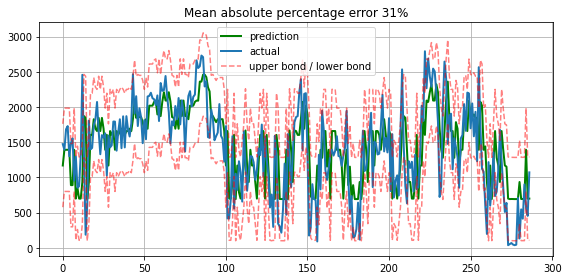

In [196]:
gbr = AdaBoostRegressor(n_estimators=10, loss='square')
gbr.fit(X_train, y_train)
plotModelResults(gbr, X_train=X_train, X_test=X_test, plot_intervals=True, plot_anomalies=False)

TS fresh - extract features:

In [197]:
df_shift, y = make_forecasting_frame(df['y'], kind='load', max_timeshift=24, rolling_direction=1)
X = extract_features(df_shift, column_id='id', column_sort='time', column_value='value', impute_function=impute)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.40s/it]


TS fresh - fit/predict:

In [198]:
ada = AdaBoostRegressor(n_estimators=10)
y_pred = [np.NaN] * len(y)

isp = 50  
assert isp > 0

for i in tqdm(range(isp, len(y))):
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)

100%|████████████████████████████████████████████████████████████████████████████████| 934/934 [04:51<00:00,  3.21it/s]


Plot predicted and actual:

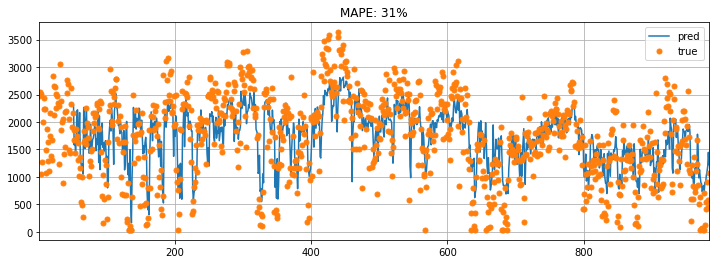

In [199]:
ys = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})
error = mean_absolute_percentage_error(ys['pred'], ys['true'])

ys['pred'].plot(figsize=(12, 4), markersize=5, style='-', legend=True)
ys['true'].plot(figsize=(12, 4), markersize=5, style='o', legend=True)
plt.grid()

plt.title('MAPE: '+str(int(error))+'%')
plt.show()

Distribution along hours:

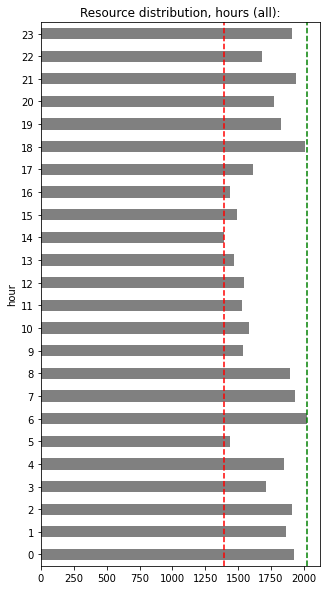

In [200]:
df['ds'] = pd.to_datetime(df['ds'])
df.dropna(inplace=True)
df['hour'] = df['ds'].dt.hour

df_class = df[['hour', 'y']].groupby('hour', as_index = True).mean()
df_class['y'].plot.barh(color='gray')

plt.axvline(x = min(df_class['y']), color='red', linestyle='--')
plt.axvline(x = max(df_class['y']), color='green', linestyle='--')

plt.title('Resource distribution, hours (all):')
plt.show()

Dynamic distribution - hours:

INFO:matplotlib.animation:Animation.save using <class '__main__.LoopingPillowWriter'>


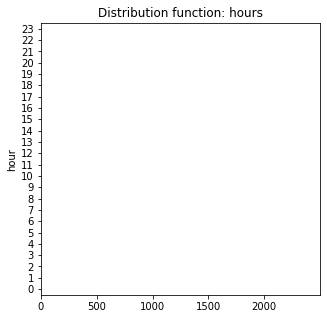

In [201]:
fig = plt.figure(figsize=(8,3))
camera = Camera(fig)

for i in range(200, len(df)):
    df_class = df[['hour', 'y']][:i].groupby('hour', as_index = True).mean()   
    df_class['y'].plot.barh(color='red', figsize=(5,5))
    plt.title('Distribution function: hours')
    camera.snap()
 
animation = camera.animate()
animation.save('cluster/hours.gif', writer = LoopingPillowWriter(fps=25))

Distribution among days:

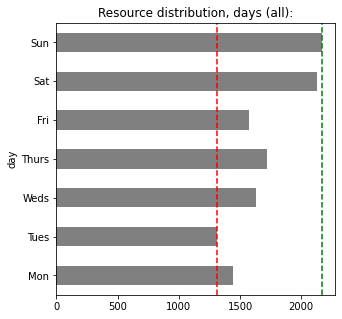

In [202]:
df['day'] = df['ds'].dt.dayofweek
day_of_week = {0: 'Mon', 1: 'Tues', 2: 'Weds', 3: 'Thurs', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df.replace({'day': day_of_week}, inplace=True)

df_class = df[['day', 'y']].groupby('day', as_index = True).mean()
df_class = df_class.reindex(['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat','Sun'])

df_class['y'].plot.barh(color='gray', figsize=(5,5))
plt.axvline(x = min(df_class['y']), color='red', linestyle='--')
plt.axvline(x = max(df_class['y']), color='green', linestyle='--')

plt.title('Resource distribution, days (all):')
plt.show()

Dynamic distribution - days:

INFO:matplotlib.animation:Animation.save using <class '__main__.LoopingPillowWriter'>


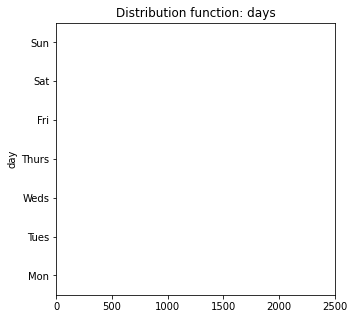

In [203]:
fig = plt.figure(figsize=(8,3))
camera = Camera(fig)

for i in range(200, len(df)):
    df_class = df[['day', 'y']][:i].groupby('day', as_index = True).mean()
    df_class = df_class.reindex(['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat','Sun'])
    
    df_class['y'].plot.barh(color='red', figsize=(5,5))
    plt.title('Distribution function: days')
    camera.snap()
 
animation = camera.animate()
animation.save('cluster/days.gif', writer = LoopingPillowWriter(fps=100000))
winsound.Beep(440, 1000)